In [2]:
from importlib import reload
from load_cluster_data import load_cluster_data

import numpy as np
import torch

import collections

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

import plotnine as p9

import scipy.sparse as sp

import matplotlib.pyplot as plt 

import nuclear_norm_PCA as knuckle # knuckle: Konvex NUClear norm Konstrained Linear Embedding
import splicing_PCA_utils

cuda


In [3]:
# load data
input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) # , celltypes = ["B", "MemoryCD4T"])

# still do preprocessing in scipy
indices = (final_data.cell_id_index, final_data.junction_id_index)

indices_np = np.stack(indices)

junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))


['B' 'CD14Mono' 'CD8T' 'DC' 'FCGR3A' 'IGHA' 'MemoryCD4T' 'NK' 'NaiveCD4T'
 'ZNF385D']


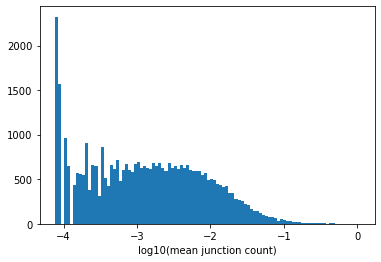

In [4]:
junc_counts_sub, cluster_counts_sub = splicing_PCA_utils.filter_junctions(
    junc_counts, cluster_counts, plot = True)

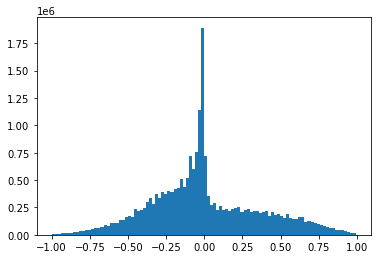

In [5]:
# set up data for nuc norm PCA
Y_data, w = splicing_PCA_utils.make_Y(
    junc_counts_sub, cluster_counts_sub, float_type)

# np.mean(Y_data * Y_data) * psi.shape[0] * psi.shape[1]
Y = torch.tensor(Y_data, **float_type)
W = torch.tensor(w.data, **float_type)

_ = plt.hist(Y_data, 100) # centered so the distribution peaks at 0 and is in [-1,1]

In [6]:
Y_train, W_train, indices_train, Y_test, W_test, indices_test = splicing_PCA_utils.train_test(
    Y_data, w, float_type)

In [ ]:
rmseTol = 5e-5
its=50

rs, testErrors, trainErrors, nuc_norms, final_svd, step_times = knuckle.constraint_search(
    indices_train, 
    Y_train, 
    W_train, 
    size = junc_counts_sub.shape,
    indices_test = indices_test, 
    Y_test = Y_test, 
    W_test = W_test, 
    rmseTol = rmseTol, 
    end = "\n",
    inner_verbose = True,
    power_iteration_controller = (30,1.),
    its = its,  
    **float_type)


CV	Bound	RMSE	TestRMSE
It	RMSE	Step	DeltaRMSE
CV	1e+03	0.317	0.32213e-055
It	RMSE	Step	DeltaRMSE
CV	1.5e+03	0.314	0.321e-055
It	RMSE	Step	DeltaRMSE
CV	2.25e+03	0.311	0.319e-05
It	RMSE	Step	DeltaRMSE
CV	3.38e+03	0.305	0.318e-05
It	RMSE	Step	DeltaRMSE
CV	5.06e+03	0.3	0.31673e-05
It	RMSE	Step	DeltaRMSE
CV	7.59e+03	0.293	0.314e-055
It	RMSE	Step	DeltaRMSE
CV	1.14e+04	0.285	0.31201123
It	RMSE	Step	DeltaRMSE
CV	1.71e+04	0.277	0.31101743
It	RMSE	Step	DeltaRMSE
CV	2.56e+04	0.27	0.309059e-05
It	RMSE	Step	DeltaRMSE
CV	3.84e+04	0.268	0.30936e-05
It	RMSE	Step	DeltaRMSE
CV	5.77e+04	0.258	0.30833e-05
It	RMSE	Step	DeltaRMSE
CV	8.65e+04	0.257	0.3085e-05
It	RMSE	Step	DeltaRMSE
CV	1.3e+05	0.251	0.30752e-055
It	RMSE	Step	DeltaRMSE
CV	1.95e+05	0.249	0.30761e-05
It	RMSE	Step	DeltaRMSE
CV	2.92e+05	0.242	0.3063e-057
It	RMSE	Step	DeltaRMSE
CV	4.38e+05	0.241	0.3069e-05
It	RMSE	Step	DeltaRMSE
CV	6.57e+05	0.24	0.30651e-05
It	RMSE	Step	DeltaRMSE
CV	9.85e+05	0.234	0.3068e-058
It	RMSE	Step	DeltaRMSE


In [9]:
1

1

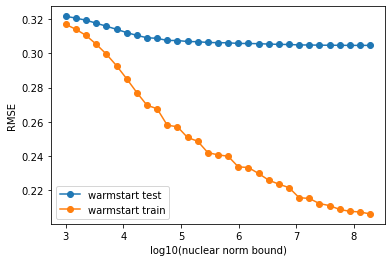

In [13]:
plt.plot(np.log10(rs), testErrors,"-o", label = "warmstart test")
plt.plot(np.log10(rs), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(nuclear norm bound)")
plt.legend()

tensor(36002.6602)

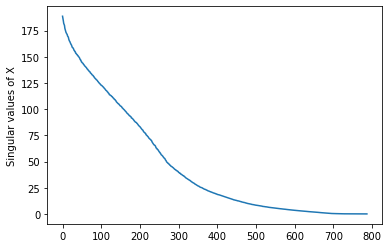

In [14]:
plt.plot(final_svd.S)
plt.ylabel("Singular values of X") 
final_svd.S.sum()

Text(0, 0.5, 'log10(Nuc norm obtained)')

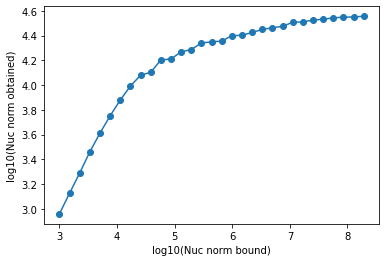

In [15]:
# solution is on the boundary up to about ~1e4, then is inside. 
plt.plot(np.log10(rs), np.log10(nuc_norms), "-o", label = "warmstart")
plt.xlabel("log10(Nuc norm bound)")
plt.ylabel("log10(Nuc norm obtained)")

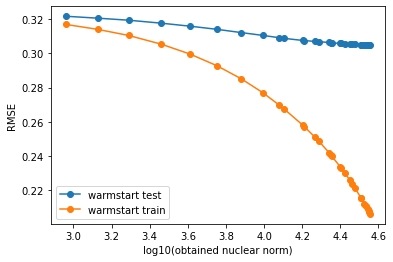

In [17]:
plt.plot(np.log10(nuc_norms), testErrors,"-o", label = "warmstart test")
plt.plot(np.log10(nuc_norms), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(obtained nuclear norm)")
plt.legend()

In [21]:
r_best = rs[np.argmin(testErrors)]
r_best

85222692.99239293

In [ ]:
r_best = 1.0e6 # minimal gains after this

In [22]:
Y,W,indices = splicing_PCA_utils.to_torch(Y_data, w, **float_type)

In [ ]:
reload(knuckle)
rs, _, trainErrors_all, nuc_norms_all, final_svd_all, step_times = knuckle.constraint_search(
    indices, 
    Y, 
    W, 
    size = junc_counts_sub.shape,
    rmseTol = rmseTol, 
    its = its,  
    max_r = r_best, 
    end = "\n",
    **float_type)


CV	Bound	RMSE	TestRMSE


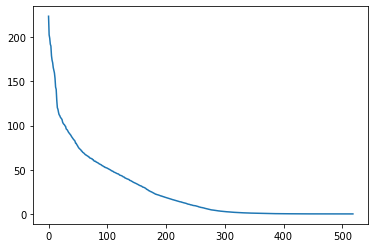

In [259]:
plt.plot(final_svd_all.S)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

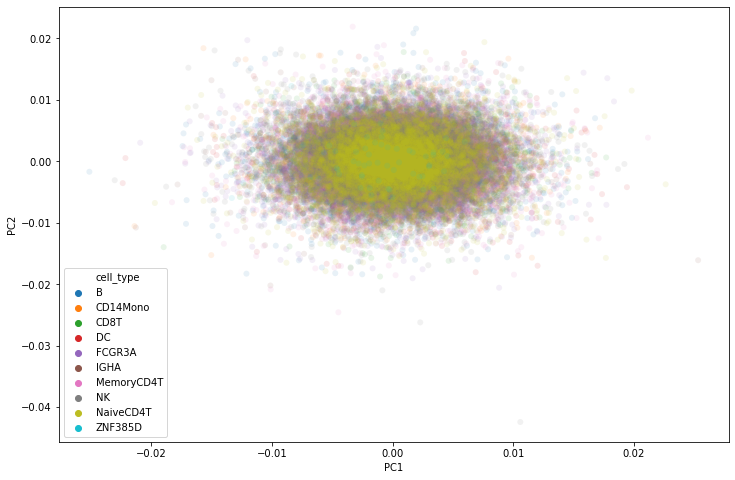

In [260]:
import pandas as pd 
import seaborn as sns
# U_mat.T @ U_mat

PC_embed_df = pd.DataFrame({"PC1" : final_svd_all.U[:,0], "PC2" : final_svd_all.U[:,1]})
PC_embed_df["cell_type"] = cell_ids_conversion["cell_type"].to_numpy()
#p9.ggplot(X_embed_df, p9.aes(x = "x", y="y", color = "cell_type")) + p9.geom_point()

#plt.figure(figsize=[8,6]) # for pdf
plt.figure(figsize=[12,8])
sns.scatterplot(x = "PC1",y = "PC2", hue="cell_type", data= PC_embed_df, edgecolor = 'none', alpha = 0.1)


(0.0, 100.0)

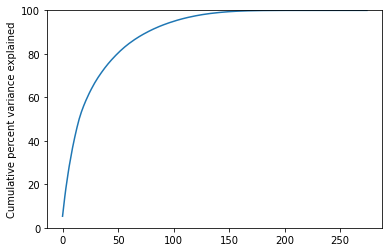

In [172]:
pve = final_svd_all.S**2
pve /= pve.sum()
pve = pve.cumsum(0) * 100
plt.plot(pve)
plt.ylabel("Cumulative percent variance explained")
plt.ylim(0,100)

In [20]:
E = final_svd_all.U * final_svd_all.S
knuckle.tsne_plot(E, cell_ids_conversion)

NameError: name 'final_svd_all' is not defined